<a href="https://colab.research.google.com/github/giutassarotti/testia/blob/main/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -r requirements.txt

     |████████████████████████████████| 1.6MB 31.0MB/s 
     |████████████████████████████████| 399kB 26.1MB/s 
     |████████████████████████████████| 552kB 34.9MB/s 
     |████████████████████████████████| 122kB 50.9MB/s 
     |████████████████████████████████| 81kB 8.8MB/s 
     |████████████████████████████████| 430kB 37.1MB/s 
     |████████████████████████████████| 71kB 7.9MB/s 
ERROR: google-colab 1.0.0 has requirement tornado~=5.1.0; python_version >= "3.0", but you'll have tornado 6.1 which is incompatible.
  Found existing installation: nbconvert 5.6.1
    Uninstalling nbconvert-5.6.1:
      Successfully uninstalled nbconvert-5.6.1
  Found existing installation: tornado 5.1.1
    Uninstalling tornado-5.1.1:
      Successfully uninstalled tornado-5.1.1
  Found existing installation: jupyter-client 5.3.5
    Uninstalling jupyter-client-5.3.5:
      Successfully uninstalled jupyter-client-5.3.5


# **Caricamento del dataframe**

In [1]:
import pandas

def io_load_multiple_csv(csv_path_list):
  dataframe_list = []
  for elem in csv_path_list:
    dataframe_list.append(io_load_csv(elem))
  return dataframe_list

def io_load_csv(csv_path):
  return pandas.read_csv(csv_path)

# **Analisi del dataset**
## **Filtraggio dei valori nulli**

Anzitutto eliminiamo dal dataset i valori che rappresentano attributi mancanti trasformandoli in NaN.

*NON SERVE*

## **Analisi del dataframe**
Definiamo ora le funzioni utili ad analizzare il dataframe fornito.

In [2]:
import numpy

def print_infos(dataframe):
  print("Dataframe miscellaneous:\n")
  print("Rows     : {}".format(dataframe.shape[0]) )
  print("Columns  : {}".format(dataframe.shape[1]))
  print("\nFeatures :\n{}".format(dataframe.columns.tolist()))
  print("\nUnique values :\n{}".format(dataframe.nunique()))

  print("\nDataframe info:")
  dataframe.info()

  for elem in dataframe:
    print(elem, ': ', numpy.sort(dataframe[elem].unique()))

In [20]:
import matplotlib.pyplot as pyplot
import seaborn

def is_categorical(elem):
  return type(elem) is str

def is_numeric(elem):
  return not is_categorical(elem)

def get_numeric_features(dataframe):
  numeric_features = []
  for elem in dataframe:
    if is_numeric(dataframe[elem][0]):
      numeric_features.append(elem)
  return numeric_features

def get_categorical_features(dataframe):
  categorical_features = []
  for elem in dataframe:
    if is_categorical(dataframe[elem][0]):
      categorical_features.append(elem)
  return categorical_features

def print_feature_plots(dataframe, feature_target):
  categorical_features = get_categorical_features(dataframe)
  print(categorical_features)
  numeric_features = get_numeric_features(dataframe)
  print(numeric_features)
  for elem in dataframe:
    if elem is feature_target:
      continue
    if elem in categorical_features:
      print("Categorical:")
      plot = seaborn.catplot(x = feature_target, 
                        col = elem, 
                        data = dataframe, 
                        kind = 'count')
    elif elem in numeric_features:
      print("Numeric:")
      plot = seaborn.displot(data = dataframe,
                        x = elem,
                        hue = feature_target) 
  
    pyplot.show()

def remove_columns(dataframe, column_list):
  for elem in column_list:
    dataframe.pop(elem)
  return dataframe

# **Modello**
Vengono sfruttate le possiilità offerte da una pipeline di sklearn per creare ed utilizzare il modello.

Come classificatore viene utilizzato l'algoritmo di Random Forest, che è un algoritmo di tipo Ensemble, e quindi sfrutta la combinazione di altri algoritmi più deboli ma opportunamente organizzati ed utilizzati per ottenere dei risultati soddisfacenti. In questo caso abbiamo una combinazione di classificatori di tipo Decision tree.

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report, plot_confusion_matrix

def create_preprocessor(dataframe):
  numeric_features = get_numeric_features(dataframe)
  numeric_transformer = Pipeline(
      steps = [('imputer', SimpleImputer(strategy='median')),
               ('scaler', StandardScaler())])

  categorical_features = get_categorical_features(dataframe)
  categorical_transformer = Pipeline(
      steps=[('imputer', SimpleImputer(strategy='most_frequent')),
             ('onehot', OneHotEncoder(handle_unknown='ignore'))])

  return ColumnTransformer(
      transformers=[('num', numeric_transformer, numeric_features),
                    ('cat', categorical_transformer, categorical_features)])

def create_model(dataframe):
  preprocessor = create_preprocessor(dataframe)

  return Pipeline(
      steps = [('preprocessor', preprocessor),
               ('classifier', RandomForestClassifier())])
  
def train_model(model, dataframe_train, dataframe_train_target):
  model.fit(dataframe_train, dataframe_train_target)
  print('Training score: {}'.format(model.score(dataframe_train, dataframe_train_target)))
  return model

def print_test_model(model, dataframe_test, dataframe_test_target):
  preds = model.predict(dataframe_test)
  print('Test score: {}'.format(model.score(dataframe_test, dataframe_test_target)))
  print(classification_report(dataframe_test_target, preds))

# **Esecuzione**
*Impostazioni di stampa*

In [5]:
numpy.set_printoptions(precision=3, suppress=True)

*Caricamento del dataset*

In [6]:
dataframe_train_path = "train.csv"
dataframe_test_path = "test.csv"

dataframe_train, dataframe_test = io_load_multiple_csv([dataframe_train_path, dataframe_test_path])
dataframe_train.head()

,Churn,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,No,4137-JOPHL,Female,0,No,No,50,Yes,No,Fiber optic,No,No,Yes,Yes,No,Yes,Two year,Yes,Bank transfer (automatic),89.70,4304.5
1,No,6917-IAYHD,Male,0,No,Yes,1,No,No phone service,DSL,No,Yes,No,Yes,No,No,Month-to-month,No,Mailed check,33.60,33.6
2,Yes,3186-BAXNB,Female,0,No,No,1,Yes,No,Fiber optic,No,Yes,No,Yes,Yes,No,Month-to-month,No,Electronic check,91.70,91.7
3,No,1403-GYAFU,Male,0,Yes,Yes,70,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),20.05,1360.25
4,Yes,9637-EIHEQ,Female,0,No,No,1,Yes,No,DSL,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,50.80,50.8


In [ ]:
print_infos(dataframe_train)

['Churn', 'customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges']
['SeniorCitizen', 'tenure', 'MonthlyCharges']
Categorical:


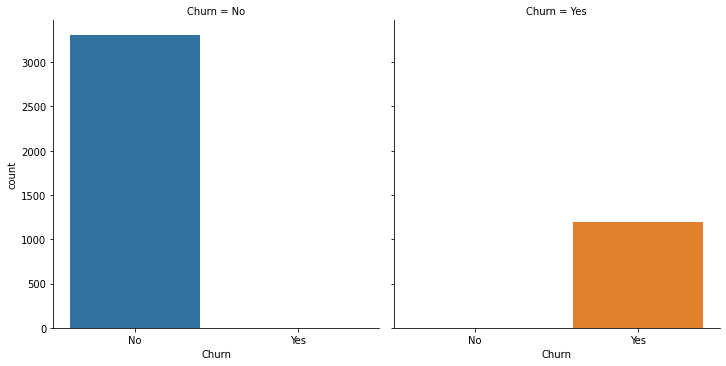

Categorical:


ValueError: ignored

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f043a687830> (for post_execute):


ValueError: ignored

ValueError: ignored

<Figure size 1.62252e+06x360 with 4507 Axes>

In [21]:
feature_target = "Churn"
print_feature_plots(dataframe_train, feature_target)